# EuroSAT RGB Land Use Image Classification

This notebook demonstrates the process of training a convolutional neural network (CNN) on the EuroSAT RGB dataset for land use classification. You’ll learn how to prepare the data, train a model, visualize results, and interpret what the model has learned using advanced visualizations like confusion matrices and Grad-CAM.

## Project Steps

1. Dataset Preparation
2. Data Loading & Preprocessing
3. Model Building & Training
4. Evaluation & Metrics
5. Advanced Visualizations (Confusion Matrix, Grad-CAM)
6. Single Image Prediction & Visualization
7. Discussion & Next Steps


## 1. Dataset Preparation

The folder structure should look like:
```
EuroSAT_RGB/
├── train/
│   ├── AnnualCrop/
│   ├── Forest/
│   └── ... (other classes)
└── test/
    ├── AnnualCrop/
    ├── Forest/
    └── ... (other classes)
```
If your data is not split, run the cell below to automatically split it. **Skip if already split!**

In [9]:
import os
import shutil
import random

base_dir = 'EuroSAT_RGB'  # Change if your base folder is elsewhere
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
split_ratio = 0.2  # Use 20% for testing

if not os.path.exists(train_dir):
    # Remove train/test if present
    for folder in [train_dir, test_dir]:
        if os.path.exists(folder):
            shutil.rmtree(folder)

    # Find class folders (excluding train/test)
    all_classes = [d for d in os.listdir(base_dir)
                   if os.path.isdir(os.path.join(base_dir, d)) and d not in ['train', 'test']]

    for folder in [train_dir, test_dir]:
        os.makedirs(folder, exist_ok=True)
        for class_name in all_classes:
            os.makedirs(os.path.join(folder, class_name), exist_ok=True)

    # Split images
    for class_name in all_classes:
        class_path = os.path.join(base_dir, class_name)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(images)
        split_idx = int(len(images) * (1 - split_ratio))
        train_imgs = images[:split_idx]
        test_imgs = images[split_idx:]
        for img in train_imgs:
            shutil.move(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in test_imgs:
            shutil.move(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))
        os.rmdir(class_path)

    print('Dataset split complete.')
else:
    print('Dataset already split. Skipping splitting step.')

Dataset already split. Skipping splitting step.


## 2. Data Loading & Preprocessing

We load the data, create validation sets, and normalize pixel values.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

batch_size = 32
img_height = 64
img_width = 64
AUTOTUNE = tf.data.AUTOTUNE

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds_raw.class_names
num_classes = len(class_names)
print('Classes:', class_names)

# Normalize pixels
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds_raw.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds_raw.map(lambda x, y: (normalization_layer(x), y))

# Performance optimizations
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 21600 files belonging to 10 classes.
Using 17280 files for training.
Found 21600 files belonging to 10 classes.
Using 4320 files for validation.
Found 5400 files belonging to 10 classes.
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


## 3. Model Building & Training

We use a simple CNN for this task. Feel free to try deeper models for better results!

In [11]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 128)       

In [12]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
540/540 [==============================] - 33s 57ms/step - loss: 1.5212 - accuracy: 0.4122 - val_loss: 1.0167 - val_accuracy: 0.6685
Epoch 2/10
166/540 [========>.....................] - ETA: 18s - loss: 1.1729 - accuracy: 0.5727

KeyboardInterrupt: 

## 4. Model Evaluation

Let's evaluate the model on the test set and plot the training history.

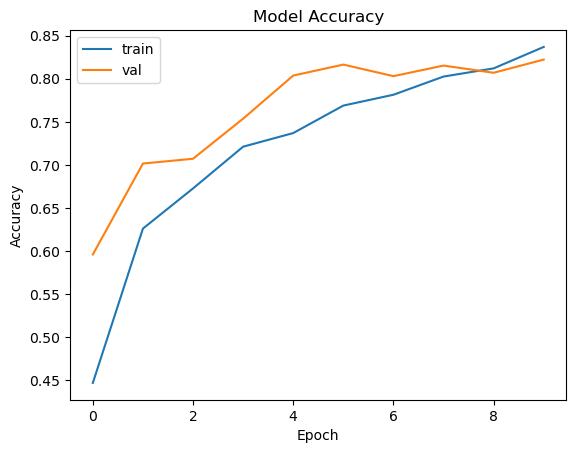

169/169 [==============================] - 4s 20ms/step - loss: 0.5041 - accuracy: 0.8311
Test Accuracy: 0.8311


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

## 5. Confusion Matrix (Advanced Visualization)
A confusion matrix shows actual vs. predicted classes, helping you see where the model is confused.

1/1 [==============================] - 0s 116ms/step


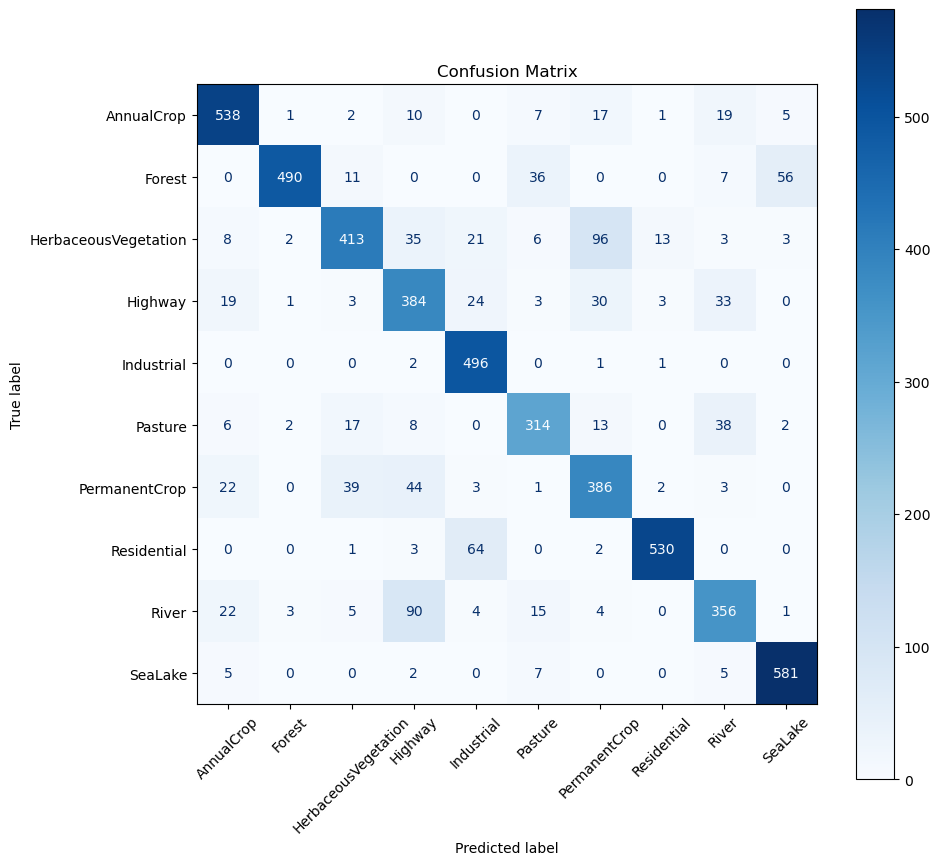

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all test images and labels
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation=45, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## 6. Grad-CAM: Model Explainability
Grad-CAM helps us visualize which part of the image most influenced the model's decision.

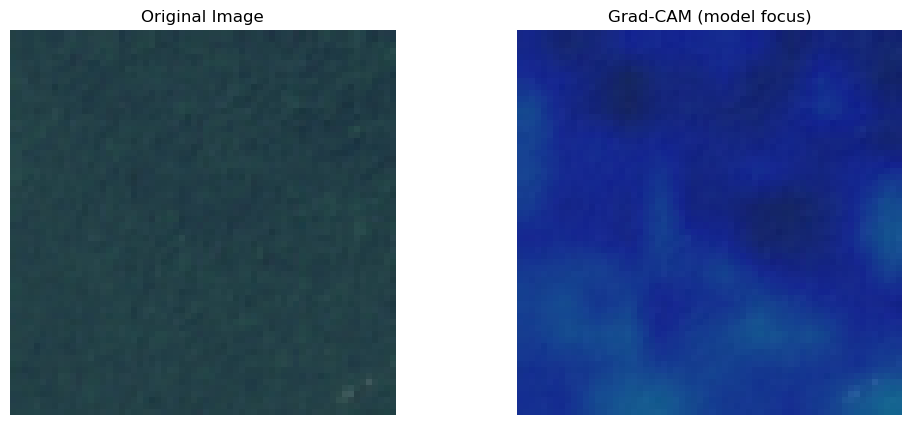

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Helper: Grad-CAM for a single image
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Pick a test image
img_path = 'EuroSAT_RGB/test/Forest/Forest_7.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Get last conv layer name
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Superimpose heatmap on image
img_disp = np.array(img)
heatmap = cv2.resize(heatmap, (img_disp.shape[1], img_disp.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_disp, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img_disp)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Grad-CAM (model focus)')
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

## 7. Single Image Prediction & Visual Explanation

Predict the class of a single image and show the result.

1/1 [==============================] - 0s 30ms/step


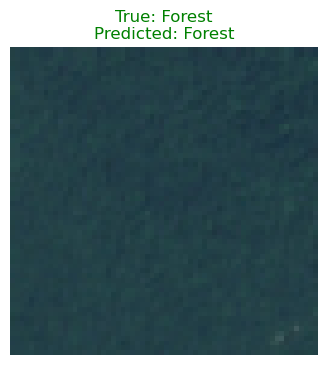

Top predictions:
Forest: 99.80%
SeaLake: 0.12%
Pasture: 0.03%


In [ ]:
img_path = 'EuroSAT_RGB/test/Forest/Forest_7.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

predictions = model.predict(img_array)
class_idx = np.argmax(predictions, axis=1)[0]
predicted_class = class_names[class_idx]
true_class = os.path.basename(os.path.dirname(img_path))
correct = (true_class == predicted_class)
title_color = 'green' if correct else 'red'

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title(f"True: {true_class}\nPredicted: {predicted_class}", color=title_color)
plt.show()

print("Top predictions:")
top_indices = np.argsort(predictions[0])[::-1][:3]
for i in top_indices:
    print(f"{class_names[i]}: {predictions[0][i]*100:.2f}%")

## 8. Discussion & Interpretation

**Test Accuracy:** Indicates the model’s overall performance on unseen data. Higher is better, but watch for overfitting.

**Confusion Matrix:** Reveals which classes the model confuses. Use it to improve the model or data.

**Grad-CAM:** Shows which parts of the image the model uses for its prediction. Useful for model trust and debugging.

**Next Steps:**
- Try data augmentation
- Experiment with deeper/pretrained models (ResNet, EfficientNet)
- Analyze per-class accuracy
- Visualize misclassifications
- Contribute improvements to this notebook!

---

_Notebook by [Your Name]. Powered by Keras & TensorFlow._